# Feature Engineering, Pipelines, and Tuning with sktime

This session covers:

- Time series transformers (in the sklearn sense)
- Manual feature engineering (what not to do)
- Forecasting pipelines
- Time-aware cross-validation
- Hyperparameter tuning


In [14]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_series, plot_windows

from sktime.datasets import load_airline
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    ForecastingGridSearchCV,
    ExpandingWindowSplitter,
)

from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.compose import make_reduction, ForecastingPipeline
from sktime.transformations.series.lag import Lag
from sktime.forecasting.base import ForecastingHorizon

from sklearn.linear_model import Ridge


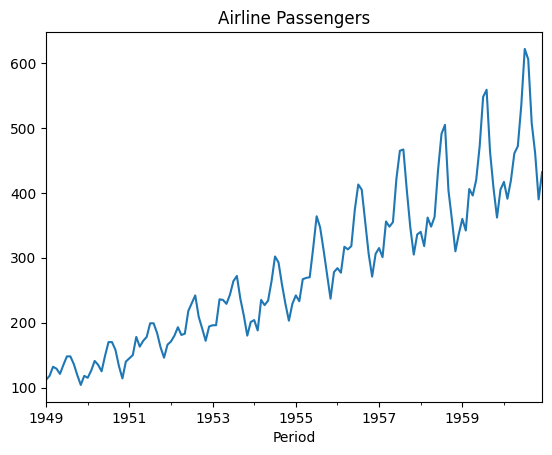

In [2]:
# Load example dataset (Airline Passengers)
y = load_airline()

y.plot(title="Airline Passengers")
plt.show()


## Train/Test Split

In [3]:
y_train, y_test = temporal_train_test_split(y, test_size=24)
fh = ForecastingHorizon(y_test.index, is_relative=False)


## Manual transformations: doing things the wrong way

We manually create lag features outside a forecasting pipeline.


In [4]:
df = pd.DataFrame({"y": y})
df["lag1"] = df["y"].shift(1)
df["lag2"] = df["y"].shift(2)
df = df.dropna()

df.head()


,y,lag1,lag2
Period,,,
1949-03,132.0,118.0,112.0
1949-04,129.0,132.0,118.0
1949-05,121.0,129.0,132.0
1949-06,135.0,121.0,129.0
1949-07,148.0,135.0,121.0


## Reduction-based forecasting

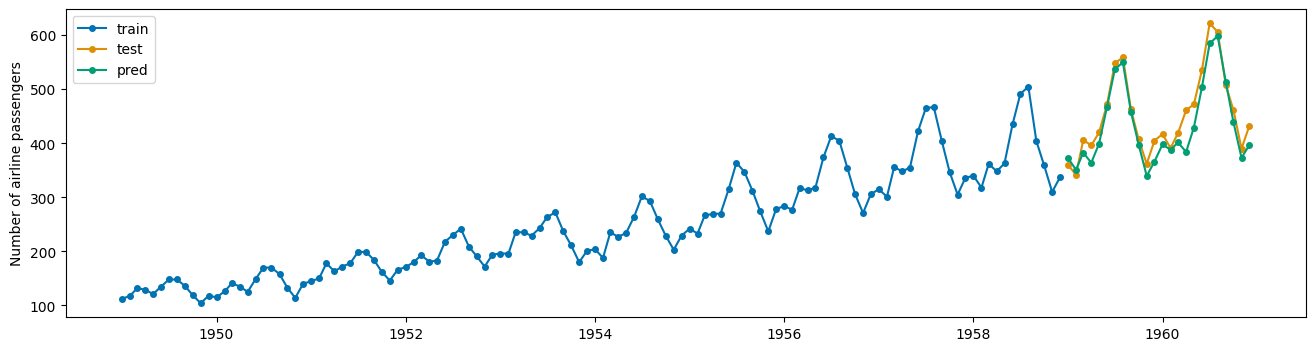

In [5]:
forecaster = make_reduction(
    Ridge(),
    window_length=12,
    strategy="recursive"
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])


## Forecasting pipeline with Lag transformer

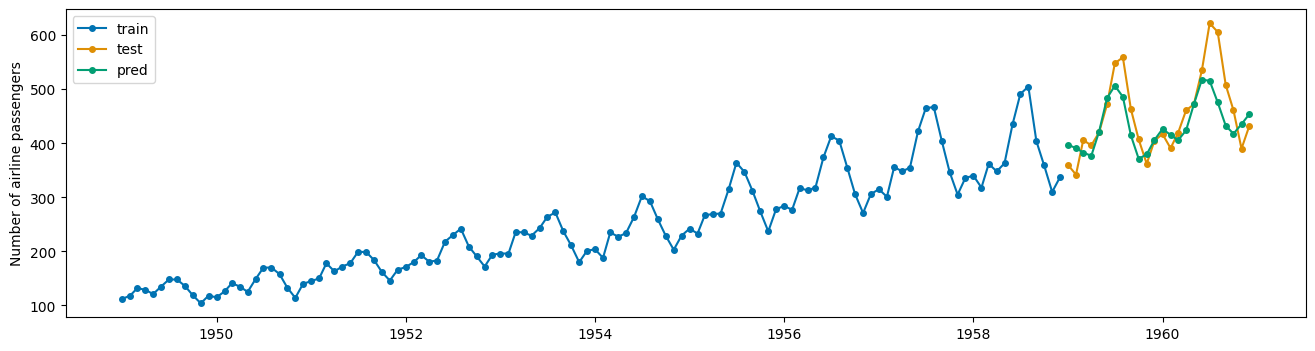

In [6]:
pipe = ForecastingPipeline(steps=[
    ("lags", Lag([1, 2, 3, 12])),
    ("model", make_reduction(Ridge(), strategy="recursive"))
])

pipe.fit(y_train)
y_pred = pipe.predict(fh)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

## Time series cross-validation

(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

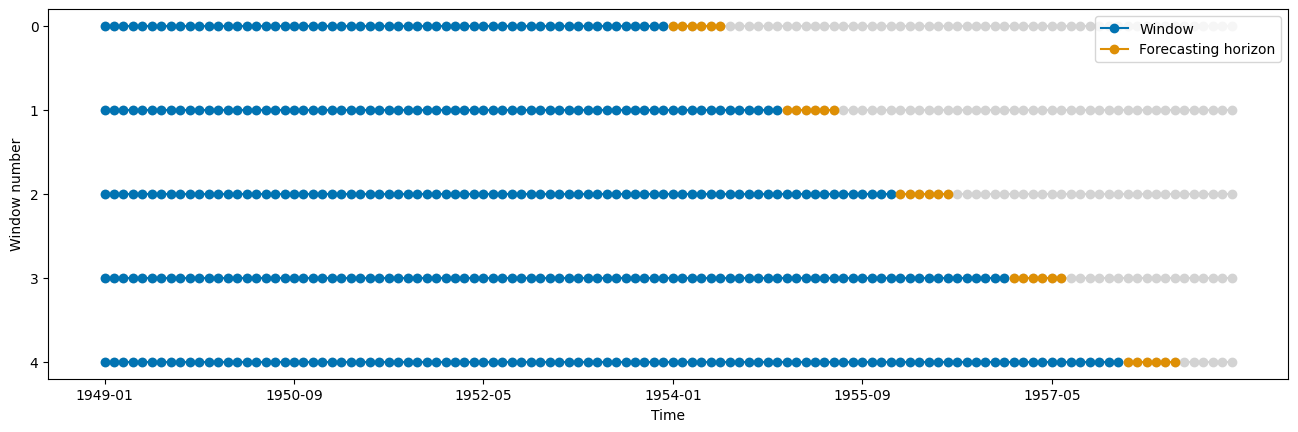

In [7]:
cv = ExpandingWindowSplitter(
    initial_window=60,
    step_length=12,
    fh=[1,2,3,4,5,6]
)

plot_windows(cv=cv, y=y_train)

In [8]:

param_grid = {
    "lags__lags": [[1,2,3], [1,2,3,12]],
    "model__estimator__alpha": [0.01, 0.1, 1, 10]
}

gscv = ForecastingGridSearchCV(
    forecaster=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=MeanSquaredError(square_root=True)
)

gscv.fit(y_train)

gscv.get_fitted_params()['best_params']

{'lags__lags': [1, 2, 3], 'model__estimator__alpha': 10}

In [9]:
gscv.best_forecaster_

ForecastingPipeline(steps=[('lags', Lag(lags=[1, 2, 3])),
                           ('model',
                            RecursiveTabularRegressionForecaster(estimator=Ridge(alpha=10)))])

## Multiple preprocessing methods and pipelining, with ExponentialSmoothing

In [10]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer, RobustScaler, MinMaxScaler
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Deseasonalizer, Detrender


forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("minmax", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("power", TabularToSeriesAdaptor(PowerTransformer())),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("forecaster", ExponentialSmoothing()),
    ]
)

# using dunder notation to access inner objects/params as in sklearn
param_grid = {
    # deseasonalizer
    "deseasonalizer__model": ["multiplicative", "additive"],
    # power
    "power__transformer__method": ["yeo-johnson", "box-cox"],
    "power__transformer__standardize": [True, False],
    # forecaster
    "forecaster__sp": [4, 6, 12],
    "forecaster__seasonal": ["add", "mul"],
    "forecaster__trend": ["add", "mul"],
    "forecaster__damped_trend": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),  # set custom scoring function
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [12]:
gscv.get_fitted_params()['best_params']

y_pred = gscv.predict(fh)

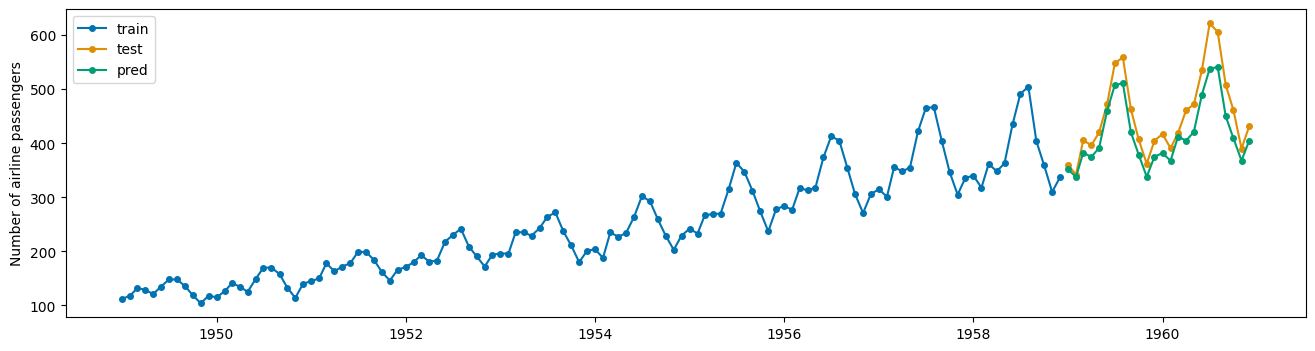

In [13]:

fig, ax = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])